<a href="https://colab.research.google.com/github/Sandeep2017/Blood_Cell-Kaggle-/blob/master/Blood_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile


%tensorflow_version 1.x
#import tensorflow as tf
import keras
from keras.layers import Dense
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from sklearn.model_selection import train_test_split



TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
local_zip = 'drive/My Drive/Blood/dataset2-master.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/blood')
zip_ref.close()

In [4]:
os.listdir('/tmp/blood')

['dataset2-master']

In [5]:
os.listdir('/tmp/blood/dataset2-master/images')

['TRAIN', 'TEST_SIMPLE', 'TEST']

In [0]:
BASE_DIR = '/tmp/blood/dataset2-master/images'

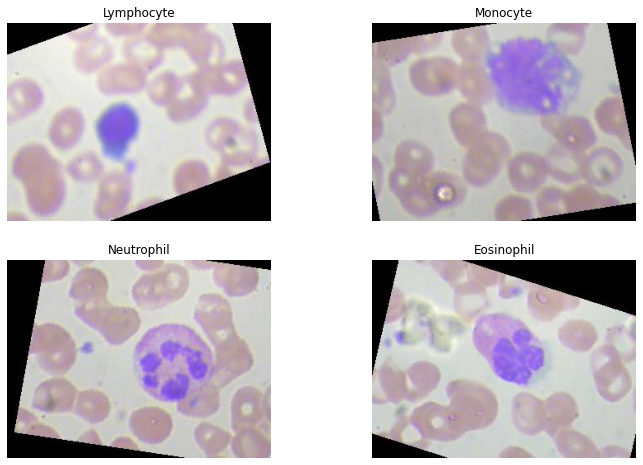

In [7]:
def Plot(image_path):
    image = cv2.imread(image_path)  # BGR
    image = image[:, :, [2, 1, 0]]  # RGB
    plt.imshow(image)
    return

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Lymphocyte'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'TRAIN/LYMPHOCYTE/_0_842.jpeg'))

plt.subplot(222)
plt.title('Monocyte'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'TRAIN/MONOCYTE/_0_1825.jpeg'))

plt.subplot(223)
plt.title('Neutrophil'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'TRAIN/NEUTROPHIL/_4_0.jpeg'))

plt.subplot(224)
plt.title('Eosinophil'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'TRAIN/EOSINOPHIL/_1_127.jpeg'))

In [8]:
print('Training samples:\n')
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
num_samples = 0

for cell in os.listdir(TRAIN_DIR): # [MONOCYTE, EOSINOPHIL, LYMPHOCYTE, NEUTROPHIL]
    
    # BASE_DIR + TRAIN + CELL (os.listdir(TRAIN))
    num_cells = len(os.listdir(os.path.join(TRAIN_DIR, cell)))
    num_samples = num_samples + num_cells
    print('Cell: {:15s} Number of samples: {}'.format(cell, num_cells))
    print("..............................................")
    
print('Total training samples: {:d}\n'.format(num_samples))

Training samples:

Cell: MONOCYTE        Number of samples: 2478
..............................................
Cell: EOSINOPHIL      Number of samples: 2497
..............................................
Cell: LYMPHOCYTE      Number of samples: 2483
..............................................
Cell: NEUTROPHIL      Number of samples: 2499
..............................................
Total training samples: 9957



In [9]:
print('Test samples:\n')
TEST_DIR = os.path.join(BASE_DIR, "TEST")
num_samples = 0

for cell in os.listdir(TEST_DIR): # [MONOCYTE, EOSINOPHIL, LYMPHOCYTE, NEUTROPHIL]
    
    # BASE_DIR + TRAIN + CELL (os.listdir(TEST))
    num_cells = len(os.listdir(os.path.join(TEST_DIR, cell)))
    num_samples = num_samples + num_cells
    print('Cell: {:15s} Number of samples: {}'.format(cell, num_cells))
    print("..............................................")
    
print('Total test samples: {:d}\n'.format(num_samples))

Test samples:

Cell: MONOCYTE        Number of samples: 620
..............................................
Cell: EOSINOPHIL      Number of samples: 623
..............................................
Cell: LYMPHOCYTE      Number of samples: 620
..............................................
Cell: NEUTROPHIL      Number of samples: 624
..............................................
Total test samples: 2487



In [0]:
IMG_SIZE = 128
#BATCH_SIZE = 32 ......98/74(history sadly deleted)
#BATCH_SIZE = 99 ......98/77(Stable)...2nd history
#BATCH_SIZE = 200......Worst 91/63........history1
#BATCH_SIZE = 12.......98.4/82..44...strange(1st history)

#BATCH_SIZE = 99 #.... new dropout values (0.1,0.5,0.5,0.5,0.5....) FULLY FUCKED UP !!
#BATCH_SIZE = 12  #.... new new dropout values (0.1,0.5,0.5,0.5,0.5....) # 75/58..26..66..81
#BATCH_SIZE = 32 #.... new new dropout values (0.1,0.5,0.5,0.5,0.5....) # Also trash

#BATCH_SIZE = 99 #.... new dropout values (0.1,0.2,0.2,0.2,0.2....) # 95/69
#BATCH_SIZE = 99 #....new dropout values (0.1,0.2,0.2,0.2,0.2....)....EPOCH = 40 ..... 97/68....EPOCH = 60 ...... 99/70
#BATCH_SIZE = 12  #....new dropout values (0.1,0.2,0.2,0.2,0.2....)....97/45

BATCH_SIZE = 12
EPOCHS = 35

#EPOCHS = 60
NUM_CLASSES = 4
CATEGORIES = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

In [123]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
                

test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [0]:
"""train_datagen = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)"""

                # 98%

In [124]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense

%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
model = Sequential()
    
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Flatten())
    
model.add(Dropout(0.1))
model.add(BatchNormalization())
    
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
    
model.add(Dense(NUM_CLASSES , activation='softmax'))

In [0]:
# New dropout values
"""
model = Sequential()
    
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
    
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(NUM_CLASSES , activation='softmax'))
"""

In [126]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 64, 64, 32)      

In [0]:
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
# lr = 0.0001 .. 98%

In [0]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
STEP_SIZE_VALID=test_generator.n // test_generator.batch_size

In [62]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)



Epoch 1/30
829/829 [==============================] - 31s 37ms/step - loss: 1.7255 - acc: 0.2883 - val_loss: 1.4576 - val_acc: 0.2874
Epoch 2/30
829/829 [==============================] - 27s 32ms/step - loss: 1.3532 - acc: 0.4233 - val_loss: 0.9300 - val_acc: 0.5568
Epoch 3/30
829/829 [==============================] - 27s 33ms/step - loss: 1.0041 - acc: 0.5708 - val_loss: 1.1652 - val_acc: 0.4893
Epoch 4/30
829/829 [==============================] - 27s 32ms/step - loss: 0.8062 - acc: 0.6565 - val_loss: 1.1451 - val_acc: 0.5119
Epoch 5/30
829/829 [==============================] - 27s 32ms/step - loss: 0.6436 - acc: 0.7299 - val_loss: 1.9017 - val_acc: 0.4760
Epoch 6/30
829/829 [==============================] - 28s 34ms/step - loss: 0.5123 - acc: 0.7844 - val_loss: 0.4875 - val_acc: 0.8251
Epoch 7/30
829/829 [==============================] - 27s 33ms/step - loss: 0.4171 - acc: 0.8284 - val_loss: 7.7793 - val_acc: 0.2537
Epoch 8/30
829/829 [==============================] - 27s 32ms

In [42]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)

Epoch 1/30
100/100 [==============================] - 22s 216ms/step - loss: 1.8203 - acc: 0.2699 - val_loss: 1.5635 - val_acc: 0.2844
Epoch 2/30
100/100 [==============================] - 19s 187ms/step - loss: 1.5821 - acc: 0.3298 - val_loss: 1.6460 - val_acc: 0.3275
Epoch 3/30
100/100 [==============================] - 19s 185ms/step - loss: 1.3301 - acc: 0.4301 - val_loss: 1.5510 - val_acc: 0.3752
Epoch 4/30
100/100 [==============================] - 18s 185ms/step - loss: 1.0744 - acc: 0.5392 - val_loss: 1.9060 - val_acc: 0.2634
Epoch 5/30
100/100 [==============================] - 18s 183ms/step - loss: 0.9542 - acc: 0.5824 - val_loss: 1.4463 - val_acc: 0.3463
Epoch 6/30
100/100 [==============================] - 19s 185ms/step - loss: 0.8478 - acc: 0.6270 - val_loss: 1.0521 - val_acc: 0.4778
Epoch 7/30
100/100 [==============================] - 18s 181ms/step - loss: 0.7516 - acc: 0.6715 - val_loss: 1.4908 - val_acc: 0.3656
Epoch 8/30
100/100 [==============================] - 1

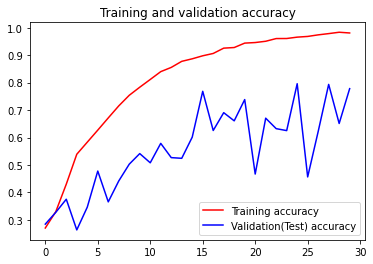

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation(Test) accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

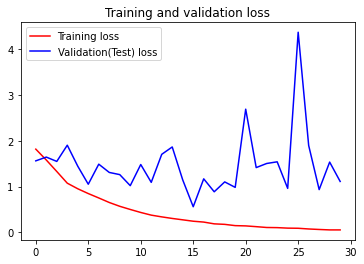

<Figure size 432x288 with 0 Axes>

99


In [48]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation(Test) loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()
print(BATCH_SIZE)

In [55]:
history1 = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)
# Worst .... BS: 200.

Epoch 1/30
49/49 [==============================] - 21s 435ms/step - loss: 1.8851 - acc: 0.2650 - val_loss: 1.5643 - val_acc: 0.2671
Epoch 2/30
49/49 [==============================] - 18s 369ms/step - loss: 1.7270 - acc: 0.2932 - val_loss: 1.7122 - val_acc: 0.2597
Epoch 3/30
49/49 [==============================] - 18s 360ms/step - loss: 1.6488 - acc: 0.3121 - val_loss: 1.5078 - val_acc: 0.3074
Epoch 4/30
49/49 [==============================] - 18s 360ms/step - loss: 1.5225 - acc: 0.3531 - val_loss: 1.4276 - val_acc: 0.3236
Epoch 5/30
49/49 [==============================] - 17s 356ms/step - loss: 1.3909 - acc: 0.4059 - val_loss: 1.2996 - val_acc: 0.3599
Epoch 6/30
49/49 [==============================] - 17s 357ms/step - loss: 1.2867 - acc: 0.4460 - val_loss: 1.1952 - val_acc: 0.4115
Epoch 7/30
49/49 [==============================] - 17s 349ms/step - loss: 1.1880 - acc: 0.4981 - val_loss: 1.4511 - val_acc: 0.3664
Epoch 8/30
49/49 [==============================] - 17s 347ms/step - 

In [72]:
history_99_NewDropout = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)
### FULL FUCKED UP .... 

Epoch 1/30
100/100 [==============================] - 22s 220ms/step - loss: 1.9649 - acc: 0.2490 - val_loss: 1.4331 - val_acc: 0.2509
Epoch 2/30
100/100 [==============================] - 18s 184ms/step - loss: 1.9140 - acc: 0.2476 - val_loss: 1.4494 - val_acc: 0.2513
Epoch 3/30
100/100 [==============================] - 18s 185ms/step - loss: 1.8681 - acc: 0.2487 - val_loss: 1.4730 - val_acc: 0.2517
Epoch 4/30
100/100 [==============================] - 18s 182ms/step - loss: 1.8253 - acc: 0.2509 - val_loss: 1.4929 - val_acc: 0.2471
Epoch 5/30
100/100 [==============================] - 18s 181ms/step - loss: 1.7769 - acc: 0.2538 - val_loss: 1.5066 - val_acc: 0.2554
Epoch 6/30
100/100 [==============================] - 18s 181ms/step - loss: 1.7440 - acc: 0.2530 - val_loss: 1.5429 - val_acc: 0.2454
Epoch 7/30
100/100 [==============================] - 18s 182ms/step - loss: 1.7253 - acc: 0.2524 - val_loss: 1.5384 - val_acc: 0.2521
Epoch 8/30
100/100 [==============================] - 1

KeyboardInterrupt: ignored

In [80]:
history_12_NewDropout = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)

Epoch 1/30
829/829 [==============================] - 32s 38ms/step - loss: 1.8873 - acc: 0.2483 - val_loss: 1.4252 - val_acc: 0.2395
Epoch 2/30
829/829 [==============================] - 27s 32ms/step - loss: 1.7979 - acc: 0.2491 - val_loss: 1.4265 - val_acc: 0.2505
Epoch 3/30
829/829 [==============================] - 27s 32ms/step - loss: 1.6998 - acc: 0.2490 - val_loss: 1.4246 - val_acc: 0.2493
Epoch 4/30
829/829 [==============================] - 27s 33ms/step - loss: 1.6321 - acc: 0.2513 - val_loss: 1.4293 - val_acc: 0.2525
Epoch 5/30
829/829 [==============================] - 27s 33ms/step - loss: 1.5789 - acc: 0.2569 - val_loss: 1.4392 - val_acc: 0.2513
Epoch 6/30
829/829 [==============================] - 27s 32ms/step - loss: 1.5450 - acc: 0.2540 - val_loss: 1.4492 - val_acc: 0.2477
Epoch 7/30
829/829 [==============================] - 27s 33ms/step - loss: 1.5190 - acc: 0.2512 - val_loss: 1.4673 - val_acc: 0.2529
Epoch 8/30
829/829 [==============================] - 27s 32ms

In [88]:
history_32_NewDropout = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)

Epoch 1/30
311/311 [==============================] - 26s 85ms/step - loss: 1.9941 - acc: 0.2468 - val_loss: 1.4718 - val_acc: 0.2496
Epoch 2/30
311/311 [==============================] - 21s 68ms/step - loss: 1.8918 - acc: 0.2444 - val_loss: 1.4927 - val_acc: 0.2489
Epoch 3/30
311/311 [==============================] - 21s 68ms/step - loss: 1.7995 - acc: 0.2525 - val_loss: 1.5193 - val_acc: 0.2530
Epoch 4/30
311/311 [==============================] - 21s 69ms/step - loss: 1.7607 - acc: 0.2438 - val_loss: 1.5150 - val_acc: 0.2517
Epoch 5/30
311/311 [==============================] - 21s 67ms/step - loss: 1.6993 - acc: 0.2590 - val_loss: 1.5339 - val_acc: 0.2477
Epoch 6/30
311/311 [==============================] - 21s 68ms/step - loss: 1.6772 - acc: 0.2537 - val_loss: 1.5051 - val_acc: 0.2521
Epoch 7/30
311/311 [==============================] - 21s 68ms/step - loss: 1.6349 - acc: 0.2495 - val_loss: 1.4960 - val_acc: 0.2525
Epoch 8/30
311/311 [==============================] - 21s 68ms

KeyboardInterrupt: ignored

In [96]:
history_99_NewDropout_0_2 = model.fit_generator(         #0_2 = 0.2
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)


ERROR! Session/line number was not unique in database. History logging moved to new session 62
Epoch 1/30
100/100 [==============================] - 24s 241ms/step - loss: 1.8879 - acc: 0.2715 - val_loss: 1.9256 - val_acc: 0.2533
Epoch 2/30
100/100 [==============================] - 18s 185ms/step - loss: 1.7382 - acc: 0.2950 - val_loss: 1.8715 - val_acc: 0.2534
Epoch 3/30
100/100 [==============================] - 19s 187ms/step - loss: 1.6122 - acc: 0.3249 - val_loss: 1.7494 - val_acc: 0.2814
Epoch 4/30
100/100 [==============================] - 18s 185ms/step - loss: 1.4741 - acc: 0.3717 - val_loss: 1.9790 - val_acc: 0.2546
Epoch 5/30
100/100 [==============================] - 19s 187ms/step - loss: 1.3427 - acc: 0.4272 - val_loss: 1.5149 - val_acc: 0.3455
Epoch 6/30
100/100 [==============================] - 19s 186ms/step - loss: 1.2081 - acc: 0.4839 - val_loss: 2.0405 - val_acc: 0.2944
Epoch 7/30
100/100 [==============================] - 18s 184ms/step - loss: 1.0422 - acc: 0.54

In [112]:
history_99_NewDropout_0_2_40 = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)


Epoch 1/60
100/100 [==============================] - 25s 253ms/step - loss: 1.8582 - acc: 0.2596 - val_loss: 1.4667 - val_acc: 0.2614
Epoch 2/60
100/100 [==============================] - 19s 189ms/step - loss: 1.7234 - acc: 0.2837 - val_loss: 1.6731 - val_acc: 0.2534
Epoch 3/60
100/100 [==============================] - 19s 189ms/step - loss: 1.6427 - acc: 0.2982 - val_loss: 1.3700 - val_acc: 0.3183
Epoch 4/60
100/100 [==============================] - 19s 190ms/step - loss: 1.5317 - acc: 0.3408 - val_loss: 1.5338 - val_acc: 0.2772
Epoch 5/60
100/100 [==============================] - 19s 188ms/step - loss: 1.4157 - acc: 0.3855 - val_loss: 1.4613 - val_acc: 0.3388
Epoch 6/60
100/100 [==============================] - 19s 189ms/step - loss: 1.2469 - acc: 0.4628 - val_loss: 1.5373 - val_acc: 0.3367
Epoch 7/60
100/100 [==============================] - 19s 188ms/step - loss: 1.0425 - acc: 0.5480 - val_loss: 3.6705 - val_acc: 0.2944
Epoch 8/60
100/100 [==============================] - 1

In [121]:
history_12_NewDropout_0_2 = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)


Epoch 1/30
829/829 [==============================] - 36s 43ms/step - loss: 1.8092 - acc: 0.2732 - val_loss: 1.7742 - val_acc: 0.2766
Epoch 2/30
829/829 [==============================] - 28s 34ms/step - loss: 1.6130 - acc: 0.3130 - val_loss: 1.5587 - val_acc: 0.3855
Epoch 3/30
829/829 [==============================] - 28s 34ms/step - loss: 1.4605 - acc: 0.3596 - val_loss: 1.2069 - val_acc: 0.3608
Epoch 4/30
829/829 [==============================] - 28s 34ms/step - loss: 1.3265 - acc: 0.4159 - val_loss: 1.1483 - val_acc: 0.4085
Epoch 5/30
829/829 [==============================] - 27s 32ms/step - loss: 1.1869 - acc: 0.4784 - val_loss: 1.4048 - val_acc: 0.3616
Epoch 6/30
829/829 [==============================] - 27s 32ms/step - loss: 1.0455 - acc: 0.5384 - val_loss: 1.3739 - val_acc: 0.3358
Epoch 7/30
829/829 [==============================] - 28s 33ms/step - loss: 0.8770 - acc: 0.6099 - val_loss: 1.5733 - val_acc: 0.3895
Epoch 8/30
829/829 [==============================] - 28s 34ms

In [129]:
history_final = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID)

Epoch 1/35
829/829 [==============================] - 35s 42ms/step - loss: 1.7729 - acc: 0.2810 - val_loss: 1.6586 - val_acc: 0.2536
Epoch 2/35
829/829 [==============================] - 27s 32ms/step - loss: 1.5152 - acc: 0.3476 - val_loss: 2.2786 - val_acc: 0.2683
Epoch 3/35
829/829 [==============================] - 27s 33ms/step - loss: 1.2259 - acc: 0.4822 - val_loss: 1.7256 - val_acc: 0.2812
Epoch 4/35
829/829 [==============================] - 27s 32ms/step - loss: 0.9576 - acc: 0.5980 - val_loss: 1.5249 - val_acc: 0.3515
Epoch 5/35
829/829 [==============================] - 27s 33ms/step - loss: 0.7572 - acc: 0.6864 - val_loss: 1.4641 - val_acc: 0.4004
Epoch 6/35
829/829 [==============================] - 27s 32ms/step - loss: 0.5948 - acc: 0.7483 - val_loss: 1.4145 - val_acc: 0.5107
Epoch 7/35
829/829 [==============================] - 26s 32ms/step - loss: 0.4600 - acc: 0.8116 - val_loss: 0.9297 - val_acc: 0.6788
Epoch 8/35
829/829 [==============================] - 26s 32ms